In [1]:
###### Basic packages
import os
from pathlib import Path
import pickle

#Data and visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import sklearn
#assert sklearn.__version__ >= "0.20"

#Validation Strategy
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, train_test_split, KFold, cross_validate, GridSearchCV

#Encoding
import category_encoders as ce

#Imputation
from sklearn.impute import SimpleImputer
import missingno as msno
from sklearn.impute import KNNImputer

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler


#Metrics
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, mean_squared_error

#Pipeline
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
from umap import UMAP
from scipy.cluster.hierarchy import dendrogram, ward

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Regression Models

import xgboost as xgb
import lightgbm as lgb
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, LassoCV
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression, RidgeCV, ElasticNetCV
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor

from sklearn.cross_decomposition import PLSRegression
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool

In [3]:
# File path and files

#File Path
data_dir = "/kaggle/input/playground-series-s3e15"
train_file = "data.csv"
#test_file = "test.csv"
orig_file = "/kaggle/input/predicting-heat-flux/Data_CHF_Zhao_2020_ATE.csv"
submission_file = "sample_submission.csv"
working_dir = "/kaggle/working/"

target = "target"

In [4]:
# test_data = Path(data_dir)/test_file
# train_data = Path(data_dir)/train_file
# submission_data = Path(data_dir)/submission_file

In [5]:
#train = pd.read_csv("/kaggle/input/playground-series-s3e15/data.csv")
# test = pd.read_csv(test_data)
# submission_df = pd.read_csv(submission_data)

In [6]:
def get_data(data_dir = data_dir,train_file = train_file,  submission_file = submission_file):
    #test_data = Path(data_dir)/test_file
    train_data = Path(data_dir)/train_file
    orig_data = Path(orig_file)
    submission_data = Path(data_dir)/submission_file
    train = pd.read_csv(train_data)
   # test = pd.read_csv(test_data)
    orig_train = pd.read_csv(orig_data)
    submission_df = pd.read_csv(submission_data)
    return train,submission_df,orig_train
    

In [7]:
train, submission_df, orig_train = get_data()

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31644 entries, 0 to 31643
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   31644 non-null  int64  
 1   author               26620 non-null  object 
 2   geometry             26144 non-null  object 
 3   pressure [MPa]       27192 non-null  float64
 4   mass_flux [kg/m2-s]  26853 non-null  float64
 5   x_e_out [-]          21229 non-null  float64
 6   D_e [mm]             26156 non-null  float64
 7   D_h [mm]             27055 non-null  float64
 8   length [mm]          26885 non-null  float64
 9   chf_exp [MW/m2]      31644 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.4+ MB


In [9]:
def create_EDA_summary (df = None):
    train_import_table = pd.DataFrame()
    train_import_table["dtype"] = df.apply(lambda x: x.dtype)
    train_import_table["NROW"] = df.shape[0]
    train_import_table["Unique_values"] = [ len(df[col].unique()) for col in df.columns]
    train_import_table["Percent_missing"] = (df.isnull().sum()/df.shape[0])*100
    
    return train_import_table

In [10]:
create_EDA_summary(df = train)

,dtype,NROW,Unique_values,Percent_missing
id,int64,31644,31644,0.000000
author,object,31644,11,15.876627
geometry,object,31644,4,17.380862
pressure [MPa],float64,31644,145,14.069018
mass_flux [kg/m2-s],float64,31644,734,15.140311
x_e_out [-],float64,31644,1683,32.913032
D_e [mm],float64,31644,44,17.342940
D_h [mm],float64,31644,50,14.501959
length [mm],float64,31644,71,15.039186
chf_exp [MW/m2],float64,31644,109,0.000000


In [11]:
train.head()

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8


In [12]:
train.rename(columns = {'x_e_out [-]':'target'}, inplace = True)

In [13]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,31644.0,15821.500000,9134.980296,0.0000,7910.7500,15821.5000,23732.2500,31643.000
pressure [MPa],27192.0,10.640747,4.333683,0.1000,6.8900,11.0700,13.7900,20.680
mass_flux [kg/m2-s],26853.0,3068.011023,1777.032080,0.0000,1519.0000,2731.0000,4069.0000,7975.000
target,21229.0,-0.000453,0.100911,-0.8667,-0.0466,0.0038,0.0648,0.232
D_e [mm],26156.0,8.629255,5.185692,1.0000,5.0000,7.8000,10.8000,37.500
D_h [mm],27055.0,14.174330,19.838489,1.0000,5.6000,10.0000,11.5000,120.000
length [mm],26885.0,832.987391,672.299239,10.0000,318.0000,610.0000,914.0000,3048.000
chf_exp [MW/m2],31644.0,3.796985,1.983991,0.8000,2.4000,3.4000,4.6000,19.300


In [14]:
#Create the test set to be predicted - Consists of all the missing values in the target variable
train["Train/Test"] = np.where(train["target"].isnull() == True, "Test", "Train")

In [15]:
train["Train/Test"].value_counts(normalize=True)

Train    0.67087
Test     0.32913
Name: Train/Test, dtype: float64

In [16]:
test = train[train["Train/Test"] == "Test"]
train = train[train["Train/Test"] == "Train"]

In [17]:
train.shape


(21229, 11)

In [18]:
#Building a basic first model

#Mean of the target variable

train = train.set_index("id")
train.head(3)

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],target,D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2],Train/Test
id,,,,,,,,,,
0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6,Train
1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2,Train
2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5,Train


In [19]:
#Start with defining the initial imputation strategy for each feature

In [20]:
train["author"].value_counts()
#use most frequent for author

Thompson        11621
Janssen          1846
Weatherhead      1377
Beus             1087
Peskov            729
Williams          567
Richenderfer      371
Mortimore         130
Kossolapov         70
Inasaka            28
Name: author, dtype: int64

In [21]:
train["geometry"].value_counts()
#Use most frequent for geometry

tube       14121
annulus     2971
plate        424
Name: geometry, dtype: int64

In [22]:
train.columns.to_list()

['author',
 'geometry',
 'pressure [MPa]',
 'mass_flux [kg/m2-s]',
 'target',
 'D_e [mm]',
 'D_h [mm]',
 'length [mm]',
 'chf_exp [MW/m2]',
 'Train/Test']

In [23]:
#List for encoding

most_freq = ["author", 'geometry']

num_features = [
 'pressure [MPa]',
 'mass_flux [kg/m2-s]',
 'D_e [mm]',
 'D_h [mm]',
 'length [mm]',
 'chf_exp [MW/m2]']

In [24]:
# Define Encoders

encoders  = [ce.OneHotEncoder(),
                     ce.CatBoostEncoder(drop_invariant = True, return_df = True),
                     ce.OrdinalEncoder(drop_invariant = True),
                     ce.TargetEncoder(drop_invariant = True),
                     ce.WOEEncoder(verbose=0, cols=None, drop_invariant=False, return_df=True, 
                              handle_unknown='value', handle_missing='value', 
                              random_state=None, randomized=False, sigma=0.05, regularization=1.0)]

In [25]:
#Feature engineering steps for cross-validation
most_freq_pipe = Pipeline([('most_freq', SimpleImputer(strategy = "most_frequent")), ("one_hot",ce.OneHotEncoder() )])

num_mean_imputation =  Pipeline([('mean',SimpleImputer(strategy = "mean")),("standard_scsaler", StandardScaler())])                        
                           
                           
#Preprocessing pipeline
preprocessor = ColumnTransformer([('most_freq', most_freq_pipe, most_freq), ('mean_impute', num_mean_imputation, num_features)])

In [26]:
#Feature pipeline with KNN for numerical features

num_knn_imputation = Pipeline([('knn',KNNImputer( weights='uniform', metric='nan_euclidean')),("standard_scsaler", StandardScaler())])
preprocessor_knn = ColumnTransformer([('most_freq', most_freq_pipe, most_freq), ('knn_impute', num_knn_imputation, num_features)])

In [27]:
#Define the model
#Define models

models = {
            "xgb": xgb.XGBRegressor(),
            #"xgb_exact": xgb.XGBRegressor(**xgb_exact_params),
            #"xgb_approx": xgb.XGBRegressor(**xgb_approx_params),
            "lgb": lgb.LGBMRegressor(),
            #"lgb2": lgb.LGBMRegressor(**lgb2_params),
            #"lgb3": lgb.LGBMRegressor(**lgb3_params),
            "cat": CatBoostRegressor(),
            #"cat2": CatBoostRegressor(**cb2_params),
           # "cat3": CatBoostRegressor(**cb3_params),
            #"cat_sym": CatBoostRegressor(**cb_sym_params),
            #"cat_loss": CatBoostRegressor(**cb_loss_params),
            #"Ridge": RidgeCV(),
            #"Lasso": LassoCV(),
            #"RandomForestRegressor": RandomForestRegressor(n_estimators=200, random_state=self.random_state, n_jobs=-1),
            #"PLSRegression": PLSRegression(n_components=10, max_iter=2000),
            #"PassiveAggressiveRegressor": PassiveAggressiveRegressor(max_iter=3000, tol=1e-3, n_iter_no_change=30, random_state=self.random_state),
            #"GradientBoostingRegressor": GradientBoostingRegressor(n_estimators=2000, learning_rate=0.05, loss="absolute_error", random_state=self.random_state),
           # "HistGradientBoostingRegressor": HistGradientBoostingRegressor(max_iter=self.n_estimators, learning_rate=0.01, loss="absolute_error", n_iter_no_change=300,random_state=self.random_state),
            #"ARDRegression": ARDRegression(n_iter=1000),
           # "HuberRegressor": HuberRegressor(max_iter=3000),
            #"KNeighborsRegressor": KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
        }


In [28]:
#Define the cross-vlidation strategy
#Cross validation strategy
seed = 42
splits = 5
#cv = RepeatedStratifiedKFold(n_splits = splits, n_repeats = 5, random_state = seed)
cv = KFold(n_splits = splits, random_state = seed, shuffle = True)


In [29]:
#Create the feature matrix and the target
train_y = train[target].values
train_X = train.drop(["target", "Train/Test"], axis = 1)

In [30]:
train_X 

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,
0,Thompson,tube,7.00,3770.0,NaN,10.8,432.0,3.6
1,Thompson,tube,NaN,6049.0,10.3,10.3,762.0,6.2
2,Thompson,NaN,13.79,2034.0,7.7,7.7,457.0,2.5
3,Beus,annulus,13.79,3679.0,5.6,15.2,2134.0,3.0
5,NaN,NaN,17.24,3648.0,NaN,1.9,696.0,3.6
...,...,...,...,...,...,...,...,...
31636,NaN,NaN,12.07,NaN,NaN,1.9,152.0,5.4
31638,Thompson,tube,NaN,3648.0,4.7,4.7,318.0,9.0
31639,Thompson,NaN,NaN,1736.0,NaN,7.8,591.0,2.3


In [31]:
type(train_y)

numpy.ndarray

In [32]:
train_y.shape, train_X.shape

((21229,), (21229, 8))

In [33]:
train_X.head()

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,
0,Thompson,tube,7.00,3770.0,NaN,10.8,432.0,3.6
1,Thompson,tube,NaN,6049.0,10.3,10.3,762.0,6.2
2,Thompson,NaN,13.79,2034.0,7.7,7.7,457.0,2.5
3,Beus,annulus,13.79,3679.0,5.6,15.2,2134.0,3.0
5,NaN,NaN,17.24,3648.0,NaN,1.9,696.0,3.6


In [34]:
#Cross-validation training loop

def cross_val_pipe(model,preprocessor = preprocessor , train_X = train_X, train_y = train_y, cv = cv, label = ''):
    
    
    #initiate prediction arrays and score lists
    train_predictions, val_predictions = np.zeros(train.shape[0]), np.zeros(train.shape[0])
   # val_predictions = np.zeros(train.shape[0]) # Validation predictions are stored in a matrix with length of the number of trainijng samples and # of preds
    train_score,val_score = [],[]
    
    
    #pipe = make_pipeline(preprocessor, model)
    
    #training model, predicting prognosis probability, and evaluating log loss
    for fold, (train_idx, val_idx) in enumerate(cv.split(train_X)):
                
        train_x= preprocessor.fit_transform(train_X.iloc[train_idx],train_y[train_idx] )
        valid_x = preprocessor.transform(train_X.iloc[val_idx])
        
        model.fit(train_x, train_y[train_idx], eval_set = [(valid_x,train_y[val_idx]),],eval_metric = "rmse" )
        
        train_pred_ = model.predict(train_x)
        val_pred_ = model.predict(valid_x)
                  
        train_predictions[train_idx] += train_pred_
        val_predictions[val_idx] += val_pred_
        
        train_score_ = mean_squared_error(train_y[train_idx], train_pred_, squared = False)
        val_score_ = mean_squared_error(train_y[val_idx], val_pred_, squared = False)
        train_score.append(train_score_)
        val_score.append(val_score_)
    
    print(f"The cross-validation score for {label} is {np.mean(val_score):.5f}")
    print(f"The standard deviation for the RMSE is {np.std(val_score):.6f}")
    return train_predictions, val_predictions, train_score, val_score

In [35]:
#model = xgb.XGBRegressor()
model = lgb.LGBMRegressor()

In [36]:
#train_predictions, val_predictions, train_score, val_score = cross_val_pipe(model = model, preprocessor = preprocessor_knn, label = "LGBM")

<AxesSubplot: >

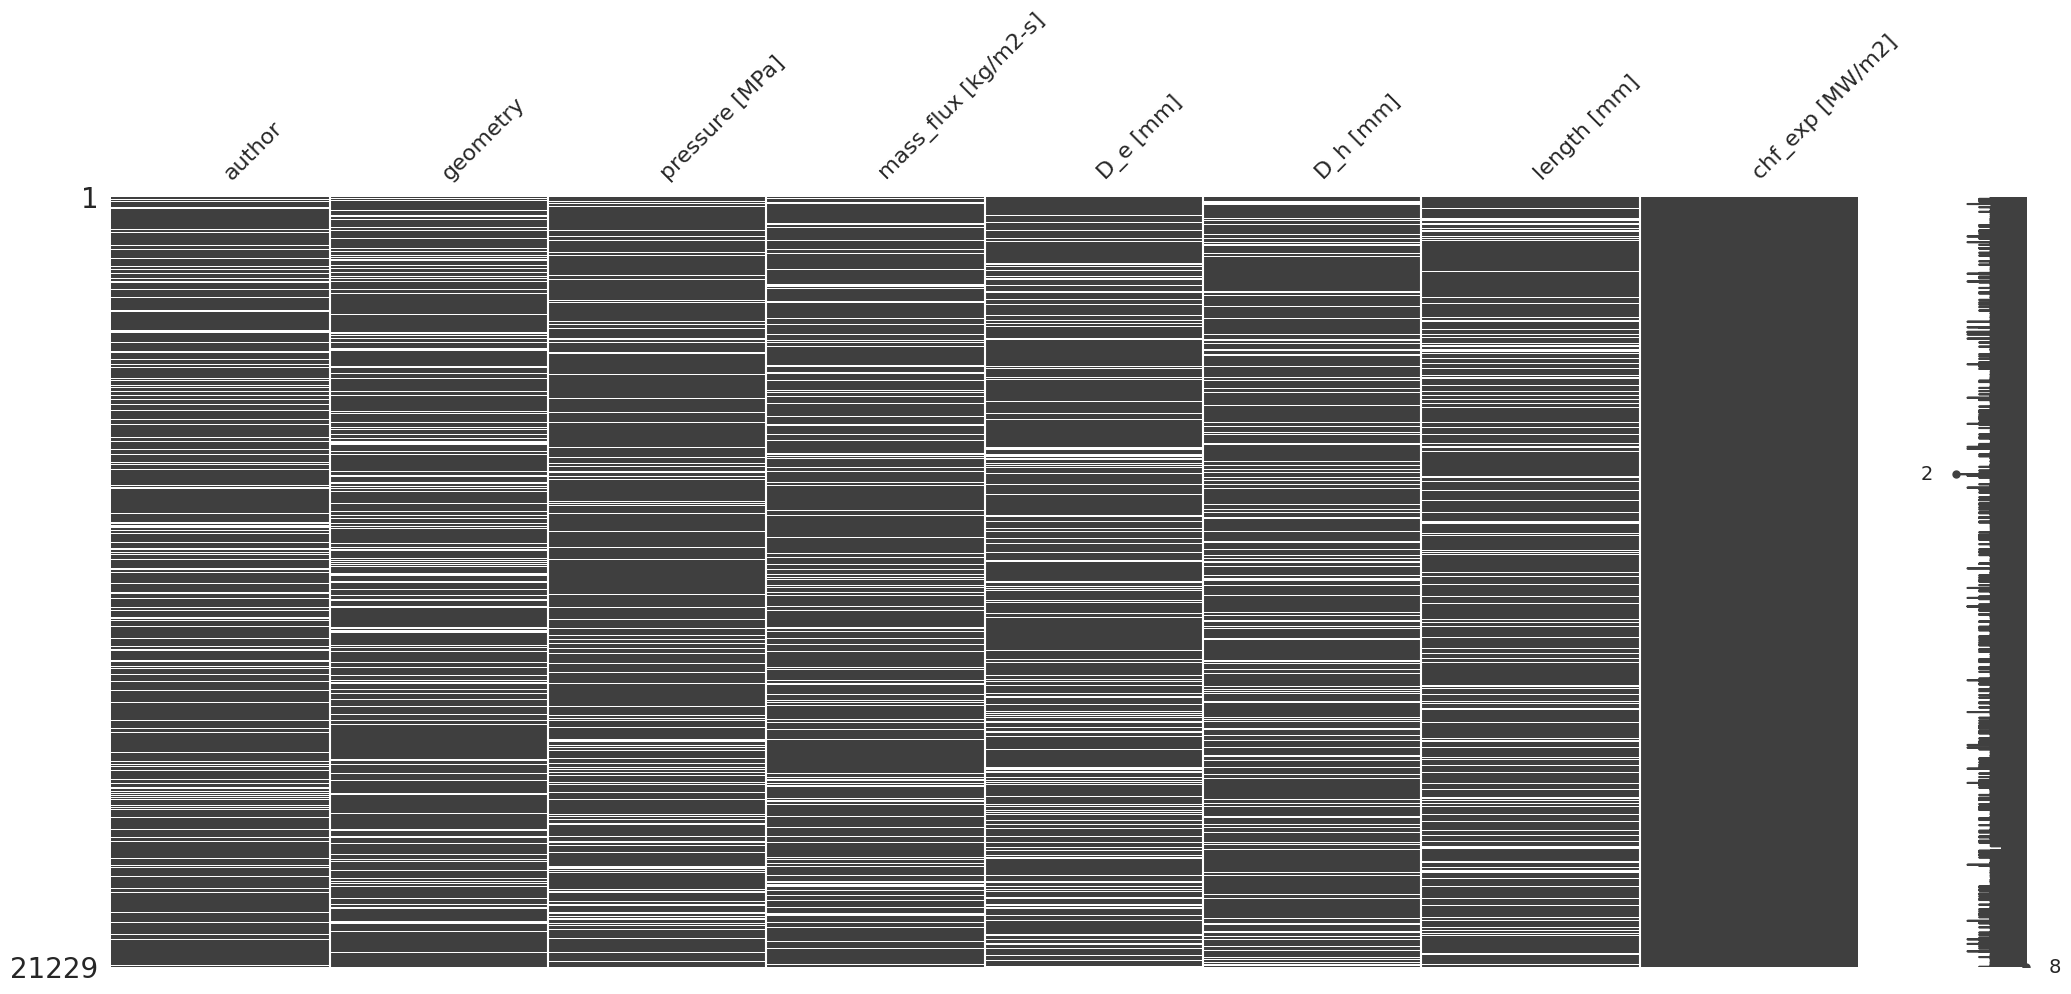

In [37]:
msno.matrix(train_X)

In [38]:
#Generate different feature engineering pipelines

#ideas - Tune the KNN - Imputation pipeline

#Need to define the search space - what parameter over what range
# How to pass this parameter to a pipeline function
#Loop over the search space and create a df with the metric for each optimisation space
#Identify the best parameter and corresponding metric



### params = {
    'columntransformer__knn_impute__knn__n_neighbors':[8,9,10,11,12,13,15,15]

}

In [40]:
lgb_params = {'metric': 'rmse',"random_state":42,
          'objective':'regression_l1', 
              'colsample_bytree': .4,
              "max_depth":8,
              "num_leaves":32,
          'verbosity': -1,
              'n_jobs': -1,
              "n_estimators":500,
          'learning_rate': 0.06,
              'subsample': .5,
                      'verbosity': -1}

In [50]:
final_model = lgb.LGBMRegressor(**lgb_params)
final_pipeline = make_pipeline(preprocessor_knn, final_model)

In [51]:
final_pipeline.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('most_freq',
                                                  Pipeline(steps=[('most_freq',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['author', 'geometry']),
                                                 ('knn_impute',
                                                  Pipeline(steps=[('knn',
                                                                   KNNImputer()),
                                                                  ('standard_scsaler',
                                                                   StandardScaler())]),
                                      

In [52]:
grid = GridSearchCV(final_pipeline, param_grid = params,scoring = "neg_root_mean_squared_error", cv = cv, verbose = 2)

In [53]:
grid

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('most_freq',
                                                                         Pipeline(steps=[('most_freq',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one_hot',
                                                                                          OneHotEncoder())]),
                                                                         ['author',
                                                                          'geometry']),
                                                                        ('knn_impute',
                                                                         Pipeline(steps=[('knn',
                                                                                          KNNImputer()),
                                                                                         ('standard_scsaler',
                                                                                          S...
                                                                          '[MW/m2]'])])),
                                       ('lgbmregressor',
                                        LGBMRegressor(colsample_bytree=0.4,
                                                      learning_rate=0.06,
                                                      max_depth=8,
                                                      metric='rmse',
                                                      n_estimators=500,
                                                      num_leaves=32,
                                                      objective='regression_l1',
                                                      random_state=42,
                                                      subsample=0.5,
                                                      verbosity=-1))]),
             param_grid={'columntransformer__knn_impute__knn__n_neighbors': [4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [45]:
#grid.fit(train_X, train_y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=4; total time=  21.9s
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=4; total time=  21.0s
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=4; total time=  21.0s
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=4; total time=  20.9s
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=4; total time=  20.9s
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=5; total time=  21.4s
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=5; total time=  20.8s
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=5; total time=  20.9s
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=5; total time=  20.4s
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=5; total time=  20.9s
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=6; total time=  20.6s
[CV] END ..columntransformer__knn_impute__knn__n_

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('most_freq',
                                                                         Pipeline(steps=[('most_freq',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one_hot',
                                                                                          OneHotEncoder())]),
                                                                         ['author',
                                                                          'geometry']),
                                                                        ('knn_impute',
                                                                         Pipeline(steps=[('knn',
                                                                                          KNNImputer()),
                                                                                         ('standard_scsaler',
                                                                                          S...
                                                                          '[MW/m2]'])])),
                                       ('lgbmregressor',
                                        LGBMRegressor(colsample_bytree=0.4,
                                                      learning_rate=0.06,
                                                      max_depth=8,
                                                      metric='rmse',
                                                      n_estimators=500,
                                                      num_leaves=32,
                                                      objective='regression_l1',
                                                      random_state=42,
                                                      subsample=0.5,
                                                      verbosity=-1))]),
             param_grid={'columntransformer__knn_impute__knn__n_neighbors': [4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [54]:
grid_search_results = grid.fit(train_X, train_y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=4; total time=  20.8s
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=4; total time=  21.3s
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=4; total time=  20.5s
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=4; total time=  20.7s
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=4; total time=  21.2s
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=5; total time=  20.7s
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=5; total time=  20.7s
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=5; total time=  20.3s
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=5; total time=  20.7s
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=5; total time=  20.6s
[CV] END ..columntransformer__knn_impute__knn__n_neighbors=6; total time=  20.3s
[CV] END ..columntransformer__knn_impute__knn__n_

In [63]:
grid_search_results.cv_results_['param_columntransformer__knn_impute__knn__n_neighbors'][:-1]

masked_array(data=[4, 5, 6, 7, 8, 9, 10, 11],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object)

In [58]:
grid_search_results.cv_results_['mean_test_score']

array([-0.07509595, -0.07500086, -0.07493664, -0.07506192, -0.07495762,
       -0.07511755, -0.07505211, -0.07497392, -0.07490041])

In [ ]:
#Fine-tune a LGBM model

num_leaf = [16,32,64,128,256, 512, 1024, 2028]
max_leaf = [4,5,6,7,8,9,10]
min_data_in_leaves_list = [20,40,60,80,100]

In [ ]:
def manual_tune_pipe(model, train_X = train_X, train_y = train_y, params = None, cv = cv, label = ''):
    
    
    #initiate prediction arrays and score lists
    train_predictions, val_predictions = np.zeros(train.shape[0]), np.zeros(train.shape[0])
   # val_predictions = np.zeros(train.shape[0]) # Validation predictions are stored in a matrix with length of the number of trainijng samples and # of preds
    train_score,val_score = [],[]
    
    model = model.set_params(**params)
    pipe = make_pipeline(preprocessor, model)
    
    #training model, predicting prognosis probability, and evaluating log loss
    for fold, (train_idx, val_idx) in enumerate(cv.split(train_X)):
                
        pipe.fit(train_X.iloc[train_idx], train_y[train_idx])
        
        train_pred_ = pipe.predict(train_X.iloc[train_idx])
        val_pred_ = pipe.predict(train_X.iloc[val_idx])
                  
        train_predictions[train_idx] += train_pred_
        val_predictions[val_idx] += val_pred_
        
        train_score_ = mean_squared_error(train_y[train_idx], train_pred_, squared = False)
        val_score_ = mean_squared_error(train_y[val_idx], val_pred_, squared = False)
        train_score.append(train_score_)
        val_score.append(val_score_)
    
    print(f"The cross-validation score for {label} is {np.mean(val_score)}")
    print(f"The number of leaves is {params}")
    return train_predictions, val_predictions, train_score, val_score

In [ ]:
for param in min_data_in_leaves_list:
    train_predictions, val_predictions, train_score, val_score = manual_tune_pipe(model = model, params = {"max_depth":8,"num_leaves":32,"min_data_in_leaf":60 }, label = "LGBM")

In [ ]:
val_score

In [ ]:

    train_predictions, val_predictions, train_score, val_score = manual_tune_pipe(model = model, params = {"max_depth":8,"num_leaves":32,"min_data_in_leaf":60 }, label = "LGBM")

In [ ]:
np.mean(val_score)

In [ ]:
#Optuna - Hyperparameter

#LGBM Optuna
def objective(trial):
    
    lgb_params = {
        'metric': 'rmse', 
        'random_state': 48,
        'n_estimators': 10000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [4,6,10,15]),
        'num_leaves' : trial.suggest_int('num_leaves', 10, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
}
    global train_X
    global train_y
    
    train_x, valid_x, y_train, y_valid = train_test_split(train_X, train_y, test_size=0.25, shuffle = True)
    
    #pipe.fit(train_X.iloc[train_idx], train_y[train_idx])
#     lg_train = lgb.Dataset(train_x, label = y_train)
#     lg_validation = lgb.Dataset(valid_x, label= y_valid)
#     evals_result_lgbm = {}
    
    model = lgb.LGBMRegressor(**lgb_params)
    pipe = make_pipeline(preprocessor, model)
#     model.fit(lgb_params, lg_train, 5000,
#                       valid_sets=[lg_train, lg_validation],
#                       early_stopping_rounds=100,
#                       verbose_eval=150,
#                       evals_result=evals_result_lgbm )
    pipe.fit(train_x, y_train)
    val_pred = pipe.predict(valid_x)
    val_metric = mean_squared_error(y_valid, val_pred, squared= False)
    
    return val_metric

In [ ]:
import optuna
from optuna.integration import CatBoostPruningCallback

study = optuna.create_study( direction="minimize")
study.optimize(objective, n_trials=40 )

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
lgb_best_params = study.best_params

In [ ]:
def pickle_save(object = None, file_name= "lgbm_params"):
    with open(file_name+'.pkl', 'wb') as f:  # open a text file
        pickle.dump(object, f) # serialize the list

In [ ]:
def pickle_load(file_name= "Dummy.pkl", variable_name = "xxx"):
    with open(Path(working_dir)/file_name, 'rb') as f:  # open a text file
        variable_name = pickle.load(f) # serialize the list
        print(variable_name)

In [ ]:
#Save the best model
pickle_save(object = lgb_best_params, file_name = "lgbm_best_params_v2")

In [ ]:
lgb_params = {'metric': 'rmse',"random_state":42,
          'objective':'regression_l1', 
              'colsample_bytree': .4,
              "max_depth":8,
              "num_leaves":32,
          'verbosity': -1,
              'n_jobs': -1,
              "n_estimators":500,
          'learning_rate': 0.06,
              'subsample': .5,
                      'verbosity': -1}
          #             ,"early_stopping_rounds":300
         #}

In [ ]:
final_model = lgb.LGBMRegressor(**lgb_params)

In [ ]:
train_predictions, val_predictions, train_score, val_score = cross_val_pipe(model = final_model, label = "LGBM_tuned")

In [ ]:
#final_model = lgb.LGBMRegressor(**lgb_best_params)

In [ ]:
final_model.get_params

In [ ]:
cross_val_pipe(model = model)

In [ ]:
#final_data = lgb.Dataset(train_X, train_y)

In [ ]:
final_pipeline = make_pipeline(preprocessor_knn,final_model)

In [ ]:
final_pipeline.get_params

In [ ]:
final_pipeline_fitted = final_pipeline.fit(train_X, train_y)

In [ ]:
test_final = test.set_index("id").drop(["Train/Test", "target"], axis = 1)

In [ ]:
predictions = pd.DataFrame(final_pipeline_fitted.predict(test_final))

In [ ]:
index = pd.DataFrame(test_final.index)

In [ ]:
sub = pd.concat([ index, predictions], axis="columns")
sub.columns = ["id","x_e_out [-]"]

In [ ]:
sub.to_csv("submission_lgb_knn_9.csv", index = False) 

In [ ]:
kaggle datasets list